# Исследование признаков

* Делаем предварительный отбор 50 лучших признаков
* Кластеризация
* Выбираем лучшие признаки из кластеров
* Строим на них модель

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../eeg-research/')

from os.path import join

import pipeline.features
import pipeline.models

base_path = '../../own_data/191104_depr_splits_features/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
from sklearn.metrics import roc_auc_score

In [5]:
def plot_curves(hist):
    pal = sns.color_palette('Set2')
    
    fig = plt.figure(figsize=[8, 4])
    l1, = plt.plot(hist.index, hist['score'], 
                   label='First timeframe, ROC-AUC = {:.2f}'.format(hist['score'].iloc[-1]),
                   color=pal[2])
    l2, = plt.plot(hist.index, hist['score_val'], 
                   label='Second (control) timeframe, ROC-AUC = {:.2f}'.format(hist['score_val'].iloc[-1]),
                   color=pal[1])
    
    lb = hist['score'] - hist['score_std'] * 1.96
    ub = hist['score'] + hist['score_std'] * 1.96
    plt.fill_between(hist.index, lb, ub, alpha=0.5, color=pal[2])
    lb = hist['score_val'] - hist['score_val_std'] * 1.96
    ub = hist['score_val'] + hist['score_val_std'] * 1.96
    plt.fill_between(hist.index, lb, ub, alpha=0.5, color=pal[1])
    plt.xlabel('Feature selection step')
    plt.ylabel('ROC-AUC')
    plt.ylim([0.5, 1.0])
    plt.legend(loc=0)
    return fig

In [6]:
def plot_roc_curve(y_true, y_pred, title=None, auc=None, save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    
    if auc is None:
        auc = roc_auc_score(y_true, y_pred)
        
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (average area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title is not None:
        plt.title(title)
    plt.legend(loc="lower right")
    if save_path:
        plt.savefig(save_path, transparent=True, dpi=150)

In [7]:
feature_methods = [
    'env-alpha',
    'env-beta',
    'coh-alpha',
    'coh-beta',
    'bands'
]


In [8]:
dir_1 = '30s_1_0_30'
dir_2 = '30s_1_30_60'
dir_3 = '30s_0_30_60'
dir_4 = '30s_0_0_30'
dir_0 = '60s_1_0_60'

df_0 = pipeline.features.get_merged_df(join(base_path, dir_0), feature_methods)
df_1 = pipeline.features.get_merged_df(join(base_path, dir_1), feature_methods)
df_2 = pipeline.features.get_merged_df(join(base_path, dir_2), feature_methods)
df_3 = pipeline.features.get_merged_df(join(base_path, dir_3), feature_methods)
df_4 = pipeline.features.get_merged_df(join(base_path, dir_4), feature_methods)

In [9]:
features = [col for col in df_1.columns if col not in ['fn', 'target']]
model = pipeline.models.LRScaled()

In [10]:
from scipy import stats

In [11]:
from sklearn.metrics import roc_auc_score

## Измеряем перформанс признаков

In [12]:
def get_scores(feat, neg=False):
    rows = []
    sign = 1 if neg is False else -1
#     for i, df in enumerate([df_1, df_2, df_3, df_4, df_0]):
    for i, df in enumerate([df_1, df_2]):
        rows.append((i + 1, feat, roc_auc_score(df['target'], sign * df[feat].fillna(0))))
    return pd.DataFrame(rows, columns=['dataframe', 'feature', 'roc_auc'])

In [13]:
dfs = []
for feat in features:
    dfs.append(get_scores(feat).groupby('feature')['roc_auc'].aggregate(['mean', 'min', 'max']))
df_feats_performance = pd.concat(dfs)
df_feats_performance['sign'] = 'pos'

In [14]:
def swap(row):
    if row['mean'] < 0.48:
        row['mean'], row['max'], row['min'] = 1 - row['mean'], 1 - row['min'], 1 - row['max']
        row['sign'] = 'neg'
    return row

In [15]:
df_feats_performance = df_feats_performance.apply(swap, axis=1)

In [16]:
df_feats_performance = df_feats_performance.sort_values('min', ascending=False)

In [17]:
pd.set_option('display.max_rows', 100)

In [18]:
df_feats_performance.reset_index(inplace=True)
df_feats_performance['chs'] = df_feats_performance['feature'].apply(lambda s: s.split('_', maxsplit=2)[-1])
df_feats_performance.set_index('feature', inplace=True)

In [19]:
df_feats_performance['paired'] = df_feats_performance['chs'].apply(lambda s: True if '_' in s else False)

In [20]:
df_feats_performance

,mean,min,max,sign,chs,paired
feature,,,,,,
env_alpha_c4_fz,0.766667,0.765657,0.767677,neg,c4_fz,True
coh_alpha_t6_c3,0.760354,0.739899,0.780808,neg,t6_c3,True
env_alpha_c4_fp2,0.759091,0.736364,0.781818,neg,c4_fp2,True
env_alpha_o2_fp2,0.758081,0.724747,0.791414,neg,o2_fp2,True
env_alpha_f3_f4,0.725000,0.723232,0.726768,neg,f3_f4,True
...,...,...,...,...,...,...
coh_alpha_o1_f7,0.481313,0.457071,0.505556,pos,o1_f7,True
env_beta_o2_fp2,0.503283,0.455556,0.551010,pos,o2_fp2,True
coh_beta_p4_f3,0.488384,0.453535,0.523232,pos,p4_f3,True


## Предварительный отбор признаков

In [21]:
from scipy import stats

In [22]:
top_features = df_feats_performance.drop_duplicates('chs').head(50).index.tolist()

In [23]:
rows = []
for feat in top_features:
    mw = stats.mannwhitneyu(
        df_1[df_1['target'] == 1][feat], 
        df_1[df_1['target'] == 0][feat], 
        alternative='less')[1]
    roc_auc = roc_auc_score(df_1['target'], -df_1[feat])
    roc_auc = max(roc_auc, 1 - roc_auc)
    mw = min(mw, 1 - mw)
    rows.append((feat, roc_auc, mw))
    
df_top_feats = pd.DataFrame(rows, columns=['feature', 'roc_auc', 'p_val'])


## Кластеризация

In [24]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [25]:
X = df_1[top_features]
corr = X.corr()
dist_vector = squareform(1 - corr)

In [26]:
l_single = linkage(dist_vector, method='single')

In [27]:
l_compl = linkage(dist_vector, method='complete')

In [28]:
l_aver = linkage(dist_vector, method='average')

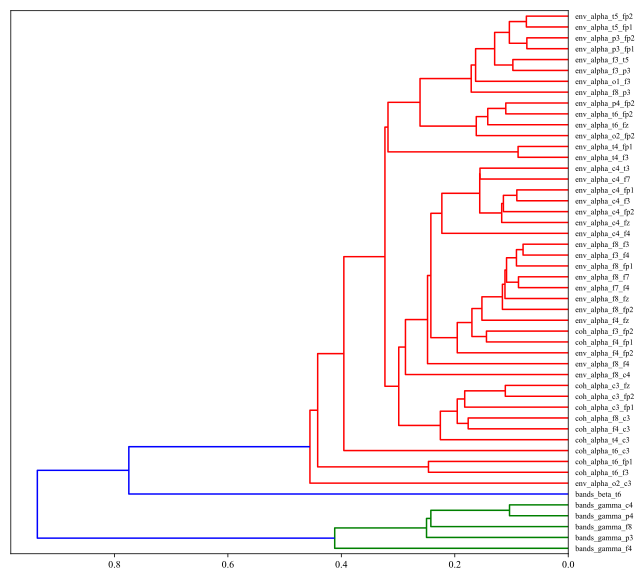

In [28]:
fig, axes = plt.subplots(figsize=[10, 10])
dendrogram(l_single, labels=top_features, orientation='left');

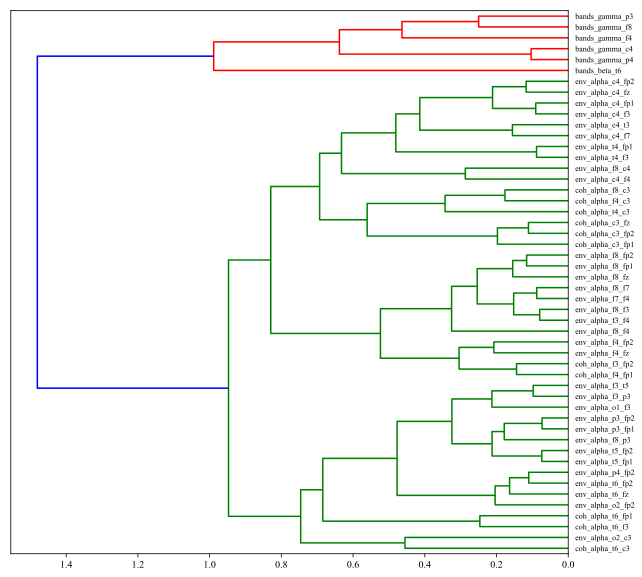

In [29]:
fig, axes = plt.subplots(figsize=[10, 10])
dendrogram(l_compl, labels=top_features, orientation='left');

## Выбираем эту дендрограмму

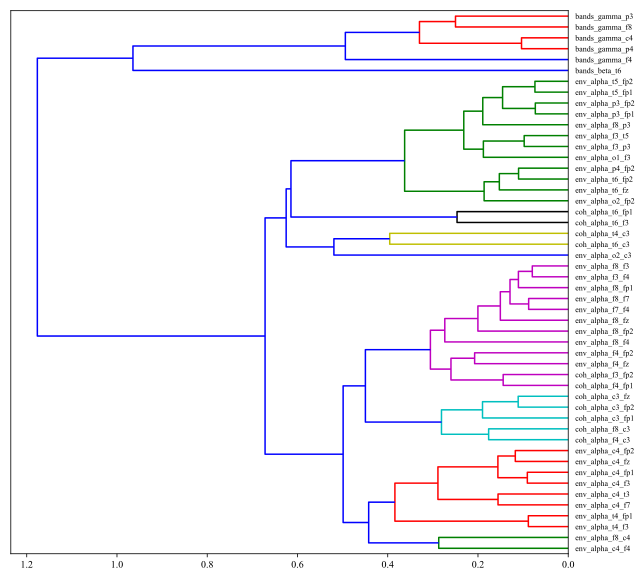

In [30]:
fig, axes = plt.subplots(figsize=[10, 10])
dendrogram(l_aver, labels=top_features, orientation='left', color_threshold=0.4);
fig.savefig('dendrogram.png', dpi=200, transparent=True, bbox_inches='tight')

In [29]:
df_feats_performance['cluster'] = -1
df_feats_performance.loc[top_features, 'cluster'] = fcluster(l_aver, t=0.4, criterion='distance')

In [30]:
top_feats_from_clusters = df_feats_performance[df_feats_performance['cluster'] > -1].drop_duplicates('cluster').index.tolist()

## Перформанс отобранных признаков от кластеров

In [31]:
rows = []
for feat in top_feats_from_clusters:
    mw = stats.mannwhitneyu(
        df_1[df_1['target'] == 1][feat], 
        df_1[df_1['target'] == 0][feat], 
        alternative='less')[1]
    roc_auc = roc_auc_score(df_1['target'], -df_1[feat])
    roc_auc = max(roc_auc, 1 - roc_auc)
    mw = min(mw, 1 - mw)
    rows.append((feat, roc_auc, mw))
    
df_top_feats = pd.DataFrame(rows, columns=['feature', 'roc_auc', 'p_val'])


In [32]:
df_top_feats

,feature,roc_auc,p_val
0,env_alpha_c4_fz,0.767677,0.000007
1,coh_alpha_t6_c3,0.739899,0.000049
2,env_alpha_o2_fp2,0.724747,0.000132
3,env_alpha_f3_f4,0.726768,0.000116
4,coh_alpha_f4_c3,0.743939,0.000038
5,env_alpha_c4_f4,0.747980,0.000028
6,bands_gamma_p4,0.696465,0.000696
7,env_alpha_o2_c3,0.687374,0.001181


In [33]:
len(top_feats_from_clusters)

8

## Корреляция топ признаков от кластеров

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


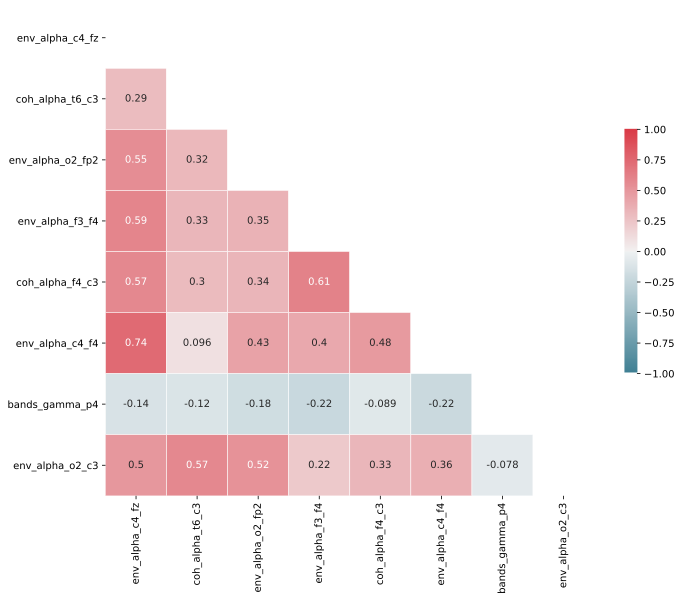

In [34]:
X = df_1[top_feats_from_clusters]
# corr = scipy.stats.spearmanr(X)[0]
corr = X.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

f.savefig('top_clust_feats_corr.png', dpi=200, transparent=True, bbox_inches='tight')

## Тест модели на отобранных признаках

In [35]:
def order_func(features, df):
    return features
res = pipeline.models.select_features(df_1, top_feats_from_clusters, pipeline.models.LRScaled(C=10), order_func=order_func, df_val=df_2)

Feature selection. Step 1


env_alpha_c4_fz


/home/max/anaconda3/envs/neuroml/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


0.7372474747474748 0.6848314606741572
coh_alpha_t6_c3
0.7733080808080809 0.7123595505617977
env_alpha_o2_fp2
0.7651767676767678 0.7219101123595506
env_alpha_f3_f4
0.7645959595959597 0.7359550561797753
coh_alpha_f4_c3
0.7762626262626263 0.7370786516853932
env_alpha_c4_f4
0.7883585858585859 0.6842696629213484
bands_gamma_p4
0.7775505050505049 0.7157303370786516
env_alpha_o2_c3
0.7840656565656566 0.6808988764044944

Feature selection. Step 2
env_alpha_c4_fz
0.7880555555555556 0.6814606741573034
coh_alpha_t6_c3
0.7410858585858586 0.65
env_alpha_c4_f4
0.7733080808080809 0.7123595505617977


In [36]:
res[2]

,feature,action,score,score_std,score_val,score_val_std
0,env_alpha_c4_fz,added,0.737247,0.010081,0.740505,0.009975
1,coh_alpha_t6_c3,added,0.773308,0.010226,0.764394,0.012290
2,env_alpha_c4_f4,added,0.788359,0.011075,0.754722,0.012996


## Почему ROC-AUC и Mann-Whithey U одно и то же

In [37]:
from scipy import stats
import statsmodels.api as sm

In [38]:
roc_auc_score(df_1['target'], df_1['coh_alpha_c4_fz'])

0.2050505050505051

In [39]:
stats.mannwhitneyu(
    df_1[df_1['target'] == 1]['coh_alpha_c4_fz'], 
    df_1[df_1['target'] == 0]['coh_alpha_c4_fz'], 
    alternative='less')                       

MannwhitneyuResult(statistic=406.0, pvalue=8.411721907136107e-07)

In [42]:
406.0 / (df_1['target'] == 1).sum() / (df_1['target'] == 0).sum()

0.20505050505050504